# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 데이터 셋 읽어오기

### 1.1 데이터 불러오기 

In [3]:
df_train = pd.read_csv("../data/train.csv") # 학습용 데이터
df_test = pd.read_csv("../data/submission.csv") # 테스트 데이터(제출파일의 데이터)

In [4]:
df_train.head() # 학습용 데이터 살펴보기

bant_submit          customer_country business_unit  com_reg_ver_win_rate  \
0          1.0  /Quezon City/Philippines            AS              0.066667   
1          1.0        /PH-00/Philippines            AS              0.066667   
2          1.0           /Kolkata /India            AS              0.088889   
3          1.0        /Bhubaneswar/India            AS              0.088889   
4          1.0          /Hyderabad/India            AS              0.088889   

   customer_idx          customer_type  enterprise  historical_existing_cnt  \
0         32160           End-Customer  Enterprise                      NaN   
1         23122           End-Customer  Enterprise                     12.0   
2          1755           End-Customer  Enterprise                    144.0   
3          4919           End-Customer  Enterprise                      NaN   
4         17126  Specifier/ Influencer  Enterprise                      NaN   

   id_strategic_ver  it_strategic_ver  ...  response_corporate  \
0               NaN               NaN  ...               LGEPH   
1               NaN               NaN  ...               LGEPH   
2               NaN               NaN  ...               LGEIL   
3               NaN               NaN  ...               LGEIL   
4               NaN               NaN  ...               LGEIL   

    expected_timeline  ver_cus ver_pro ver_win_rate_x ver_win_ratio_per_bu  \
0  less than 3 months        1       0       0.003079             0.026846   
1  less than 3 months        1       0       0.003079             0.026846   
2  less than 3 months        1       0       0.003079             0.026846   
3  less than 3 months        1       0       0.003079             0.026846   
4  less than 3 months        0       0       0.003079             0.026846   

        business_area business_subarea lead_owner is_converted  
0  corporate / office      Engineering          0         True  
1  corporate / office      Advertising          1         True  
2  corporate / office     Construction          2         True  
3  corporate / office      IT/Software          3         True  
4  corporate / office              NaN          4         True  

[5 rows x 29 columns]

In [5]:
df_test.head()

id  bant_submit                                   customer_country  \
0  19844         0.00                                        /  / Brazil   
1   9738         0.25  400 N State Of Franklin Rd  Cloud IT / Johnson...   
2   8491         1.00                                         /  / U.A.E   
3  19895         0.50                         / Madison  / United States   
4  10465         1.00                               / Sao Paulo / Brazil   

  business_unit  com_reg_ver_win_rate  customer_idx          customer_type  \
0            ID              0.073248         47466           End Customer   
1            IT                   NaN          5405           End Customer   
2            ID                   NaN         13597  Specifier/ Influencer   
3            ID              0.118644         17204                    NaN   
4            ID              0.074949          2329           End Customer   

   enterprise  historical_existing_cnt  id_strategic_ver  ...  \
0  Enterprise                     53.0               NaN  ...   
1         SMB                      NaN               NaN  ...   
2         SMB                      NaN               NaN  ...   
3  Enterprise                      NaN               NaN  ...   
4  Enterprise                      2.0               1.0  ...   

   response_corporate   expected_timeline ver_cus  ver_pro ver_win_rate_x  \
0               LGESP                 NaN       1        0       0.001183   
1               LGEUS                 NaN       0        0       0.000013   
2               LGEGF  less than 3 months       0        0       0.000060   
3               LGEUS    more than a year       0        0       0.001183   
4               LGESP  less than 3 months       1        1       0.003079   

  ver_win_ratio_per_bu           business_area     business_subarea  \
0             0.049840                  retail  Electronics & Telco   
1                  NaN          transportation               Others   
2             0.131148  hospital & health care     General Hospital   
3             0.049840                  retail                  NaN   
4             0.064566      corporate / office          Engineering   

  lead_owner is_converted  
0        278         True  
1        437         True  
2        874         True  
3        194        False  
4        167        False  

[5 rows x 30 columns]

### 1-2. 데이터셋 파악

#### 데이터 타입 

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

#### 타입별 개수 

In [21]:
df_train.dtypes.value_counts()

object     15
float64     8
int64       5
bool        1
Name: count, dtype: int64

#### 박스플롯(수치형)

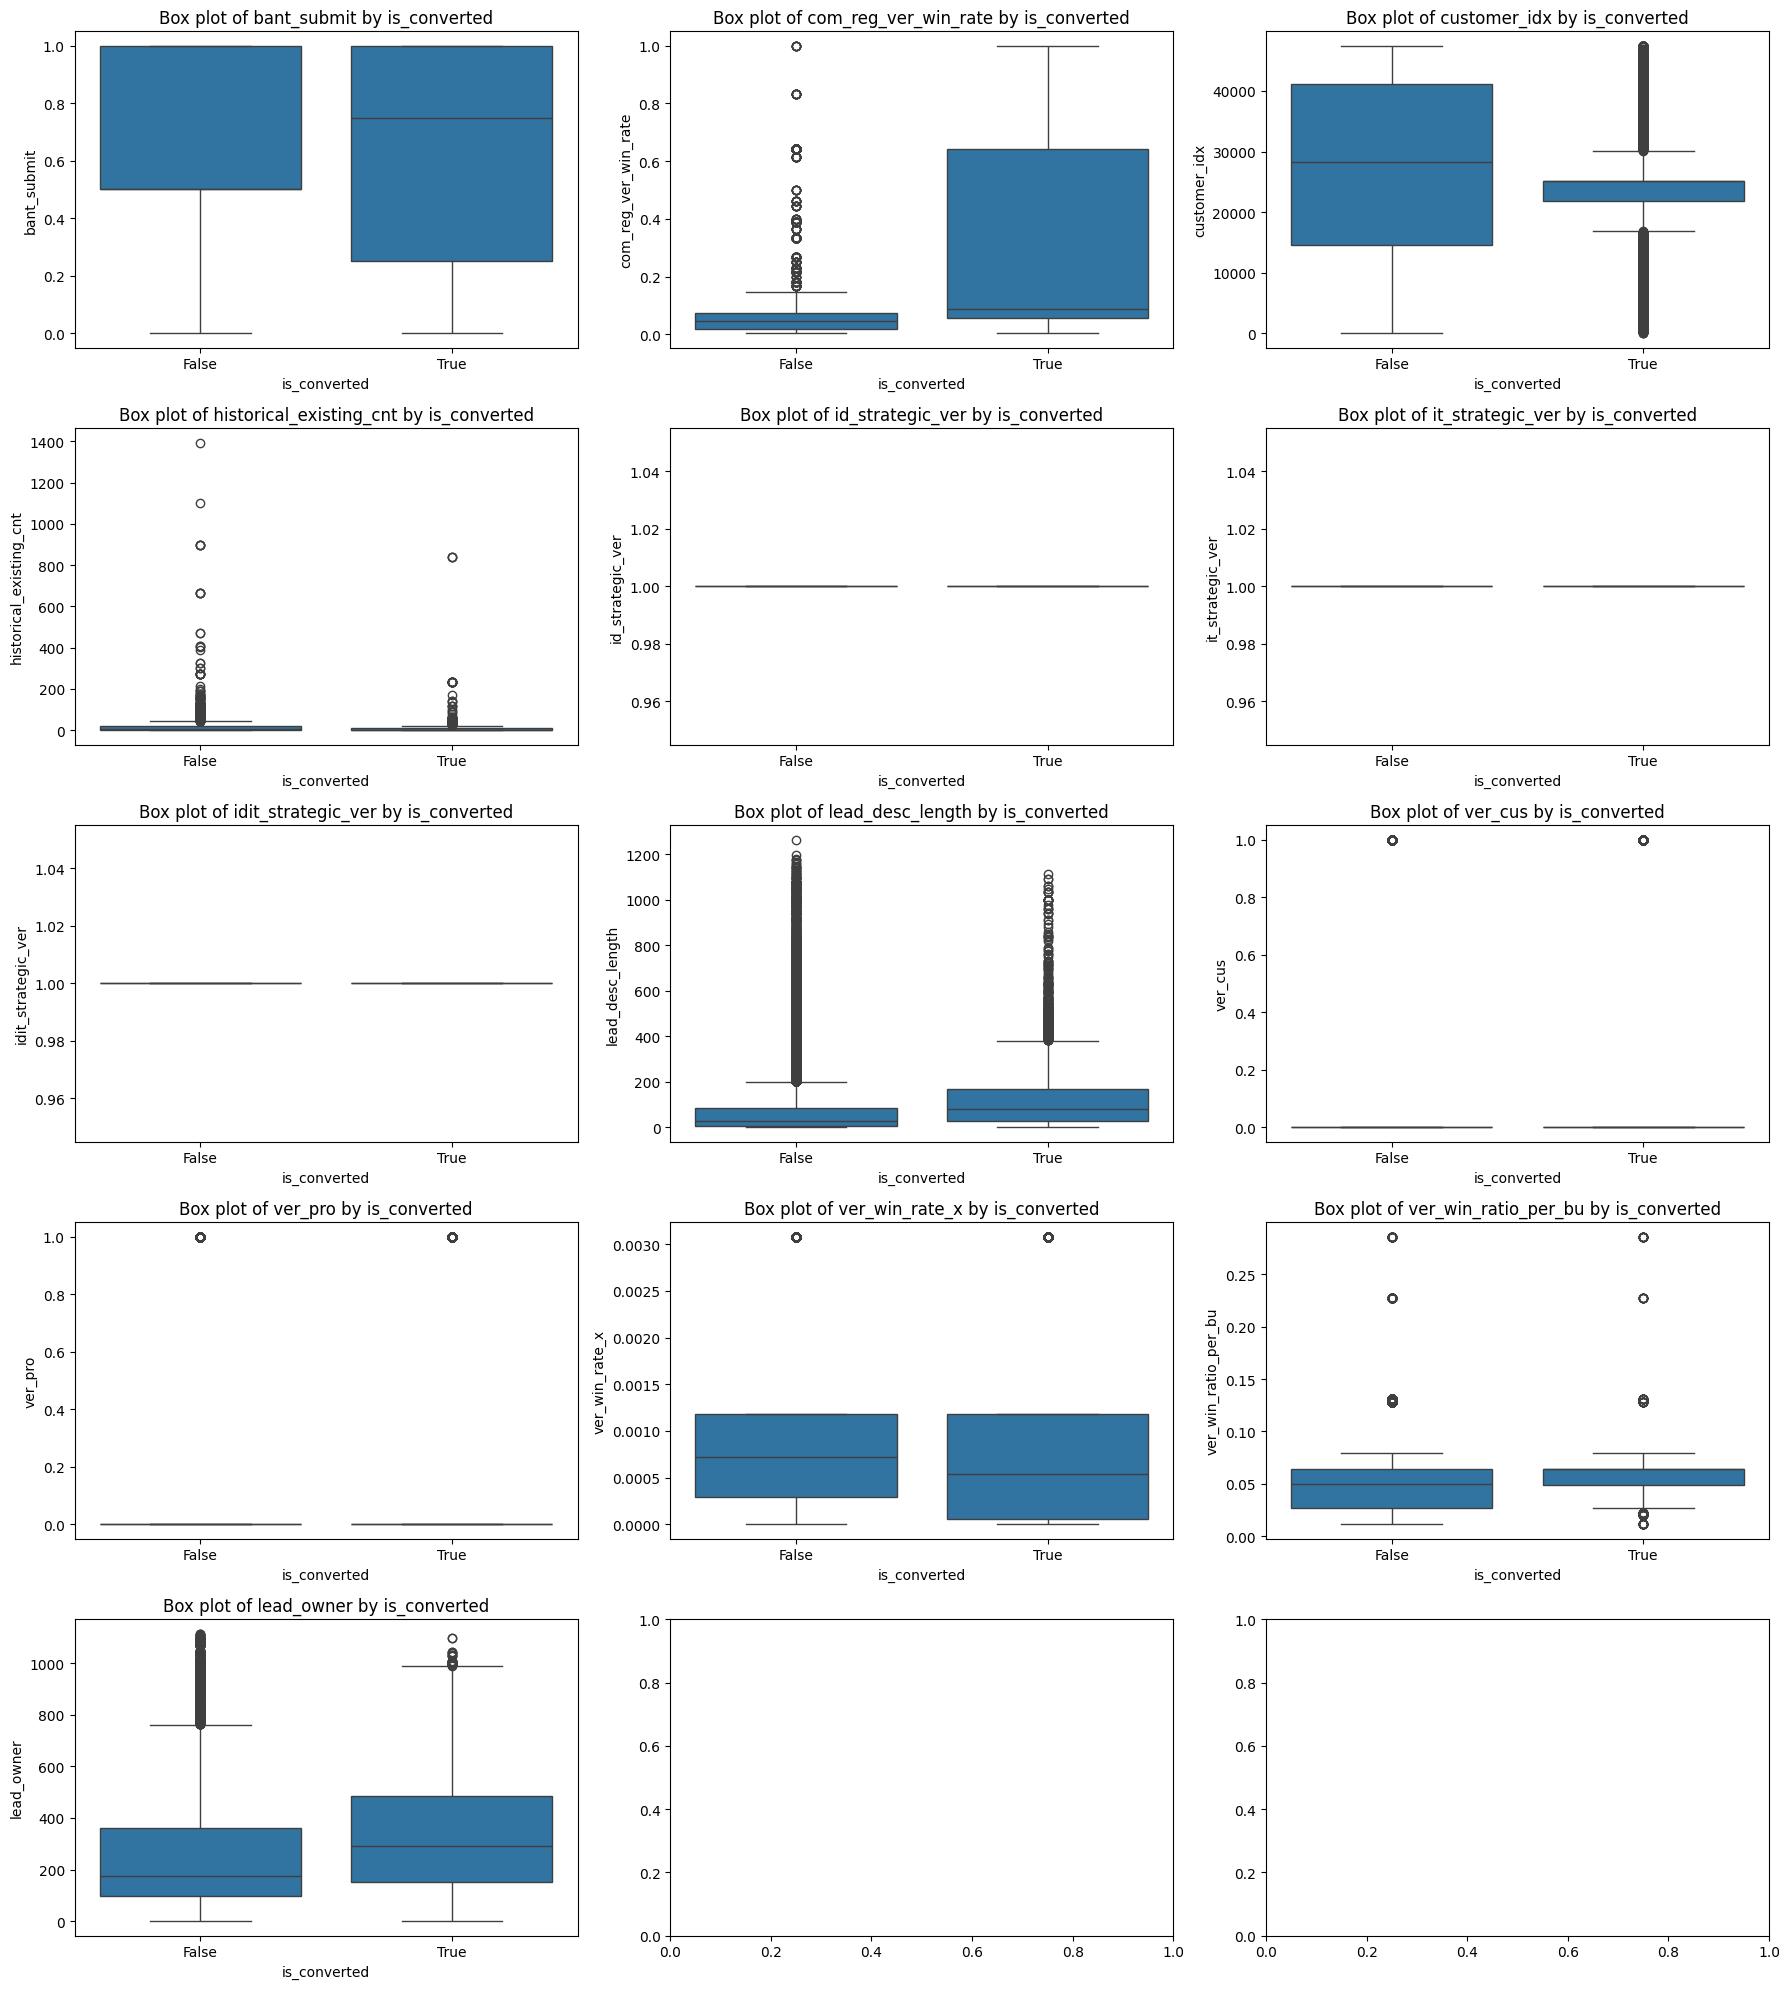

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 수치형 변수만 선택
numeric_vars = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 변수의 개수에 따라 적절한 행과 열의 개수 설정
n = len(numeric_vars)
ncols = 3  # 열의 개수를 설정
nrows = n // ncols if n % ncols == 0 else n // ncols + 1  # 행의 개수 계산

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4))

for i, var in enumerate(numeric_vars):
    r = i // ncols
    c = i % ncols
    sns.boxplot(x='is_converted', y=var, data=df_train, ax=axs[r, c])
    axs[r, c].set_title('Box plot of ' + var + ' by is_converted')

plt.tight_layout()
plt.show()

#### 변수별 통계량 산출

In [13]:
df_train.describe()

bant_submit  com_reg_ver_win_rate  customer_idx  \
count  59299.000000          14568.000000  59299.000000   
mean       0.634593              0.091685  27114.556333   
std        0.286066              0.150988  14653.911888   
min        0.000000              0.003788      2.000000   
25%        0.500000              0.019900  14913.000000   
50%        0.500000              0.049180  26774.000000   
75%        1.000000              0.074949  40368.500000   
max        1.000000              1.000000  47466.000000   

       historical_existing_cnt  id_strategic_ver  it_strategic_ver  \
count             13756.000000            3444.0            1121.0   
mean                 19.912184               1.0               1.0   
std                  44.697938               0.0               0.0   
min                   0.000000               1.0               1.0   
25%                   1.000000               1.0               1.0   
50%                   4.000000               1.0               1.0   
75%                  19.000000               1.0               1.0   
max                1394.000000               1.0               1.0   

       idit_strategic_ver  lead_desc_length       ver_cus       ver_pro  \
count              4565.0      59299.000000  59299.000000  59299.000000   
mean                  1.0         79.271590      0.041603      0.050810   
std                   0.0        132.551067      0.199681      0.219612   
min                   1.0          1.000000      0.000000      0.000000   
25%                   1.0          7.000000      0.000000      0.000000   
50%                   1.0         29.000000      0.000000      0.000000   
75%                   1.0         92.000000      0.000000      0.000000   
max                   1.0       1264.000000      1.000000      1.000000   

       ver_win_rate_x  ver_win_ratio_per_bu    lead_owner  
count    18417.000000          15304.000000  59299.000000  
mean         0.001117              0.049288    262.563888  
std          0.001104              0.027949    231.605681  
min          0.000002              0.011583      0.000000  
25%          0.000298              0.026846     97.000000  
50%          0.000572              0.049840    175.000000  
75%          0.001183              0.064566    374.000000  
max          0.003079              0.285714   1114.000000

#### 범주형 변수 속 카테고리 개수 파악

In [22]:
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

customer_country       15399
business_unit              5
customer_type             33
enterprise                 2
customer_job             560
inquiry_type              71
product_category         357
product_subcategory      330
product_modelname        665
customer_country.1     15399
customer_position        117
response_corporate        53
expected_timeline        449
business_area             12
business_subarea          86
dtype: int64

#### 나라끼리 묶기

In [18]:
import numpy as np

def process_customer_country(df):
    for i, entry in enumerate(df["customer_country"]):
        if isinstance(entry, str):
            if entry.count('/') == 2:
                last_slash_index = entry.rfind('/')
                if last_slash_index != -1 and last_slash_index != len(entry) - 1:
                    df.at[i, "customer_country"] = entry[last_slash_index + 1:].strip()
                else:
                    df.at[i, "customer_country"] = np.nan
            else:
                df.at[i, "customer_country"] = np.nan
        else:
            df.at[i, "customer_country"] = np.nan
    return df

df_train = process_customer_country(df_train)

print(df_train["customer_country"])

0                                              Philippines
1                                              Philippines
2                                                    India
3                                                    India
4                                                    India
5                                                  Nigeria
6                                             Saudi Arabia
7                                                    India
8                                              Philippines
9                                                    India
10                                                   India
11                                                   India
12                                                   India
13                                                 Nigeria
14                                                 Nigeria
15                                            Saudi Arabia
16                                               Singapo

#### 범주형 변수 파악 

##### customer_country

In [43]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['customer_country'].unique(), columns=['customer_country'])
counts = df_train['customer_country'].value_counts()
table_df['count'] = counts.reset_index(drop=True)

# 테이블 출력
table_df

customer_country    count
0                                          Philippines  16707.0
1                                                India   7978.0
2                                              Nigeria   3708.0
3                                         Saudi Arabia   2494.0
4                                            Singapore   2287.0
5                                               Brazil   1915.0
6                                                U.A.E   1587.0
7                                         South Africa   1441.0
8                                        United States   1409.0
9                                             Colombia   1196.0
10                                              Mexico   1109.0
11                                               Ghana   1092.0
12                                               Egypt    881.0
13                    Democratic Republic of the Congo    791.0
14                                            Ethiopia    567.0
15                                           Australia    559.0
16                                                 NaN    471.0
17                                               Kenya    447.0
18                                                Oman    366.0
19                                            Pakistan    363.0
20                                      United Kingdom    326.0
21                                           Guatemala    271.0
22                                              Panama    267.0
23                                              Canada    265.0
24                                          Bangladesh    262.0
25                                    Papua New Guinea    244.0
26                         United Republic of Tanzania    231.0
27                                           Indonesia    218.0
28                                               Qatar    193.0
29                                         Afghanistan    189.0
30                                               Chile    170.0
31                                          Mozambique    167.0
32                                              Turkey    160.0
33                                             Türkiye    118.0
34                                         El Salvador    110.0
35                                                Togo    105.0
36                                                Iraq    100.0
37                                              Israel     97.0
38                                         South Korea     92.0
39                                            Portugal     90.0
40                                          Mauritania     84.0
41                                             Uruguay     82.0
42                                                Peru     77.0
43                                             Germany     74.0
44                                             Romania     71.0
45                                              Norway     70.0
46                                             Jamaica     70.0
47                                             Hungary     66.0
48                           Connecticut United States     65.0
49                                              Poland     62.0
50                                               Czech     59.0
51                                               Spain     47.0
52                                           Argentina     47.0
53                                             Ecuador     45.0
54                                             Senegal     44.0
55                                           Hong Kong     43.0
56                                            Malaysia     42.0
57                                              Kuwait     41.0
58                                             Ireland     41.0
59                                             Albania     39.0
60                                              Greece     38.0
61                                             Algeria     33.0
62    

##### business_unit

In [44]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['business_unit'].unique(), columns=['business_unit'])
counts = df_train['business_unit'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

business_unit  count
0            AS  25563
1            ID  24774
2            IT   8664
3      Solution    296
4            CM      2

##### customer_type

In [45]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['customer_type'].unique(), columns=['customer_type'])
counts = df_train['customer_type'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

customer_type   count
0                   End-Customer  6647.0
1          Specifier/ Influencer  3996.0
2                Service Partner  2525.0
3                Channel Partner  1368.0
4                            NaN   349.0
5                      Corporate   146.0
6                   End Customer    52.0
7         Specifier / Influencer    43.0
8           Solution Eco-Partner    31.0
9                    Distributor    23.0
10                         Other    20.0
11             System Integrator    17.0
12                    Consultant    16.0
13                     Installer    15.0
14                     Homeowner    10.0
15                        Others    10.0
16                    Technician     8.0
17          Installer/Contractor     8.0
18                      Engineer     7.0
19            Manager / Director     6.0
20                     Developer     5.0
21                          Etc.     5.0
22          Architect/Consultant     5.0
23                      End-user     5.0
24                 HVAC Engineer     5.0
25                      Reseller     4.0
26    Software/Solution Provider     4.0
27  Software / Solution Provider     2.0
28            Dealer/Distributor     2.0
29           Technical Assistant     1.0
30           Commercial end-user     1.0
31             Interior Designer     1.0
32                    Home Owner     1.0
33                 Administrator     NaN

##### enterprise

In [46]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['enterprise'].unique(), columns=['enterprise'])
counts = df_train['enterprise'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

enterprise  count
0  Enterprise  37783
1         SMB  21516

##### customer_job

In [47]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['customer_job'].unique(), columns=['customer_job'])
counts = df_train['customer_job'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

customer_job   count
0                                           purchasing  6342.0
1                              media and communication  4852.0
2                                          engineering  3359.0
3                                     entrepreneurship  2287.0
4                                           consulting  2218.0
5                       program and project management  1961.0
6                                                sales  1938.0
7                                                other  1937.0
8                                           operations  1801.0
9                                                  NaN  1349.0
10                                      administrative  1276.0
11                                business development  1192.0
12                              information technology  1161.0
13                                          accounting   948.0
14                                           education   763.0
15                                 healthcare services   709.0
16                                     human resources   632.0
17                                             support   573.0
18                                             finance   463.0
19                                           marketing   396.0
20                                               legal   358.0
21                                   quality assurance   331.0
22                                     arts and design   295.0
23                                         real estate   241.0
24                    military and protective services   235.0
25                                            research   227.0
26                                  product management   207.0
27                                              bidder   198.0
28                       community and social services   155.0
29                                    research/install   148.0
30                                     project manager   137.0
31                                           technical   134.0
32                                        details send   118.0
33                                           architect   111.0
34                                            curation    85.0
35                                  developer/property    57.0
36                              radiology professional    53.0
37                                   graphic/color art    48.0
38                          medical imaging specialist    46.0
39                           medical solution provider    42.0
40                                             manager    39.0
41                                               owner    28.0
42                                            designer    27.0
43                                           recommend    19.0
44                              consultant / purchaser    19.0
45                                    system installer    18.0
46                         technical advisor, reseller    17.0
47                                         director it    16.0
48                                           execution    16.0
49                                      owning company    16.0
50                                president for sennco    15.0
51                 artist, lead on equipment selection    14.0
52                              specifier / integrator    14.0
53                                    systems designer    13.0
54                                       public bidder    13.0
55                                 technology designer    12.0
56                                               buyer    11.0
57                                 project coordinator    11.0
58                           research and instalaltion    11.0
59                                               vp/gm    11.0
60                                        project lead    10.0
61                                        manufacturer    10.0
62                                             av tech    10.0
63        

##### inquiry_type

In [48]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['inquiry_type'].unique(), columns=['inquiry_type'])
counts = df_train['inquiry_type'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

inquiry_type    count
0                  Quotation or purchase consultation  23274.0
1                                 Product Information  18766.0
2                  Quotation or Purchase Consultation   9977.0
3                                               Other   1237.0
4                     Usage or technical consultation    929.0
5                                           Trainings    668.0
6                                            Services    434.0
7                                       Sales Inquiry    429.0
8                                                Etc.    415.0
9                                   Technical Support    352.0
10                    Usage or Technical Consultation    297.0
11                             Technical Consultation    230.0
12                            Request for Partnership    184.0
13                                                NaN    160.0
14                                              sales    158.0
15                                          technical    128.0
16                    usage or technical consultation    110.0
17                    usage_or_technical_consultation    100.0
18                                              other    100.0
19                 quotation_or_purchase_consultation     95.0
20                                             other_     75.0
21                                     Request a Demo     63.0
22                        Request for Distributorship     37.0
23                  Request for quotation or purchase     22.0
24                   Request for technical consulting     12.0
25                                  (Select ID_Needs)     10.0
26                                     One Quick:Flex     10.0
27                                                AIO     10.0
28                                              Needs      8.0
29                                           Purchase      5.0
30                             technical_consultation      5.0
31                               Customer Suggestions      5.0
32                                      Event Inquiry      4.0
33                                             Others      4.0
34                                    OEM/ODM Request      3.0
35                                        Hospital TV      2.0
36                                             others      2.0
37                i want to know the details about it      2.0
38                             EDUCATIONAL EQUIPMENTS      2.0
39                                   Digital platform      2.0
40                                     TV interactive      2.0
41                                              teach      1.0
42                        Display Textbook and photos      1.0
43                           High inch 86 / 98 or 110      1.0
44                                         quotation_      1.0
45                              Purchase or Quotation      1.0
46                                    display product      1.0
47                             first Info and pricing      1.0
48                                      Sales inquiry      1.0
49  estoy buscando para Ecuador este producto LG M...      1.0
50  Hola me pueden cotizar 19 pantallas interactiv...      1.0
51                              window facing product      1.0
52  Vui lòng báo giá giúp mình sản phẩm đo thân nh...      1.0
53                                     Probeam precio      1.0
54                 Quotation or Purchase consultation      1.0
55                                  Hotel TV products      1.0
56               Pantallas Interactivas para Clinicas      1.0
57  Solicito apoyo para realizar cotizacion de los...      1.0
58                 Intégrateur historique du George V      1.0
59                                               ETC.      1.0
60                                                IDB      1.0
61                                      Not specified      1.0
62                                         for school      1.0
63       

##### product_category

In [49]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['product_category'].unique(), columns=['product_category'])
counts = df_train['product_category'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

product_category   count
0                                          multi-split  6154.0
1                                         single-split  5640.0
2                                                  vrf  3674.0
3                                              chiller  2029.0
4                                                 etc.  2018.0
5                                                  rac  1895.0
6                             teto ou cassete inverter  1862.0
7                                                  NaN  1569.0
8                                    software solution  1447.0
9                                   all lg vrf systems  1350.0
10                                         ventilation  1112.0
11                        a thermodynamic water heater  1051.0
12                         residential air conditioner   996.0
13                                              outros   962.0
14                                             heating   768.0
15                                        multi v5 vrf   762.0
16                                       split tunggal   668.0
17                                      multi inverter   655.0
18                                               חימום   477.0
19                                    standard signage   420.0
20                             high brightness signage   308.0
21                                 interactive signage   263.0
22                                  video wall signage   257.0
23                                         led signage   224.0
24                                            hotel tv   219.0
25                               signage care solution   191.0
26                                        oled signage   179.0
27                                                 idb   172.0
28                                          video wall   153.0
29                                    one:quick series   144.0
30                                       commercial tv   114.0
31                                        lg one:quick   112.0
32                                     special signage    90.0
33                                               other    83.0
34                                         accessories    80.0
35                                  commercial display    74.0
36                           interactive digital board    61.0
37                                            standard    60.0
38                                         uhd signage    55.0
39                                    smart tv signage    54.0
40                                 lg one:quick series    51.0
41                                         pro:centric    50.0
42                                               ur640    50.0
43                                              ur640s    48.0
44                                               webos    46.0
45                              signage care solutions    42.0
46                                     aio | one quick    41.0
47                                     high brightness    37.0
48                                         hospital tv    34.0
49                                     digital signage    34.0
50                                             monitor    31.0
51                                                  pc    30.0
52                                              laptop    29.0
53                                           projector    28.0
54                                        cloud device    25.0
55                                     medical display    22.0
56                               washing machine,dryer    22.0
57                                       solar,chiller    21.0
58                                       system ac,rac    21.0
59     monitor signage,commercial tv,monior/monitor tv    20.0
60                   monitor signage,monior/monitor tv    19.0
61                            aircare,built-in/cooking    19.0
62   monitor signage,commercial tv,monior/monitor t...    18.0
63   m

##### product_subcategory

In [50]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['product_subcategory'].unique(), columns=['product_subcategory'])
counts = df_train['product_subcategory'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

product_subcategory  count
0                                                  NaN  446.0
1                   New High Haze UHD Standard Signage  417.0
2                                Window Facing Display  374.0
3                                       LG CreateBoard  288.0
4                                        UR640S Series  284.0
5                                         TR3DJ Series  280.0
6                                    webOS UHD Signage  268.0
7                                          TN3F Series  246.0
8                                          SM3G Series  243.0
9        55" 500 nits FHD 0.44mm Even Bezel Video Wall  228.0
10                                       UH5F-H Series  209.0
11                           Interactive Digital Board  180.0
12                                         Createboard  167.0
13                                      UHD TV Signage  156.0
14       55" 700 nits FHD 0.44mm Even Bezel Video Wall  151.0
15                                       LT340C Series  127.0
16                       Ultra Narrow Bezel Video Wall  124.0
17                         Fine-pitch Essential Series  120.0
18                                       UT640S Series  114.0
19                                     Outdoor Display  108.0
20                                        TR3BG Series  102.0
21                                       SuperSign CMS   94.0
22                                    Touch Open Frame   93.0
23                                       LT341H Series   88.0
24                                 Total Care Solution   87.0
25                                   Ultra Slim Series   87.0
26                                           LG MAGNIT   85.0
27                              Wallpaper OLED Signage   84.0
28                             Indoor Versatile Series   80.0
29                                         VL5F Series   76.0
30                                    Transparent OLED   75.0
31                                         TA3E Series   73.0
32                                       OneQuick Flex   73.0
33                                                UL3J   72.0
34                                      Compact Series   71.0
35                                        TR3BF Series   70.0
36                                     4K UHD Smart TV   69.0
37                                Transparent LED Film   65.0
38                                      One:Quick Flex   63.0
39                      One:Quick Works for Zoom Rooms   63.0
40                            Transparent OLED Signage   61.0
41                                    LG Simple Editor   60.0
42                                         VH7B Series   60.0
43                      Transparent OLED Touch Signage   58.0
44                            Full HD Standard Signage   58.0
45                                         VL7F Series   58.0
46              49" 500 nits FHD Slim Bezel Video Wall   56.0
47                                    OLED Pro Monitor   55.0
48                                     One:Quick Works   54.0
49                          UltraFine Display OLED Pro   54.0
50                             SuperSign Simple Editor   48.0
51                                         SM5J Series   48.0
52                                   Flat OLED Signage   47.0
53                              Built-in Touch Display   46.0
54                            Indoor Versatile Series    45.0
55                    UHD Large Screen Signage Display   42.0
56                    LG LED All-in-One Premium Series   42.0
57                      LG LED All-in-One Smart Series   42.0
58              55" 500 nits FHD Slim Bezel Video Wall   40.0
59                                     One:Quick Share   38.0
60                          High Brightness Video Wall   38.0
61                                       LT560H Series   37.0
62                                         UH5F Series   37.0
63                                        LV35A Series   37.0
64   

##### product_modelname

In [51]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['product_modelname'].unique(), columns=['product_modelname'])
counts = df_train['product_modelname'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

product_modelname  count
0                                                  NaN  523.0
1                                             98UH5J-H  479.0
2                                               75XS4G  350.0
3                                              86TR3DK  290.0
4                                             43UR640S  261.0
5                                              86TR3DJ  199.0
6                                             75UL3J-B  167.0
7                                             22SM3G-B  167.0
8                                              55VSM5J  159.0
9                                             55UH5F-H  152.0
10                                              75TC3D  152.0
11                                             86TR3PJ  143.0
12                                     65UR640S (ASIA)  139.0
13                                             55VSH7J  132.0
14                                       43LT340C (EU)  117.0
15                                             55LV77D  115.0
16                                            LAS009-F  104.0
17                                     55UT640S (ASIA)   94.0
18                                             98TR3PJ   94.0
19                                             75TR3DJ   93.0
20                                             55TR3BG   88.0
21                                             65TR3DK   88.0
22                                             43TNF5J   85.0
23                                       43LT341H (EU)   83.0
24                                            55UL3J-B   77.0
25                                   55UR640S (EU/CIS)   77.0
26                                            55UR640S   76.0
27                                             LSAB009   73.0
28                                             LSCA039   72.0
29                                            55VL5F-A   72.0
30                                              55EW5G   70.0
31                                              43TA3E   68.0
32                                             43HT3WJ   63.0
33                                              43UL3J   61.0
34                                              86TR3E   60.0
35                                           65TR3BF-B   59.0
36                                    65UQ801C (INDIA)   55.0
37                                            32LT340C   54.0
38                                              LAT140   54.0
39                                             LSCB018   53.0
40                                          55CT5WJ-ZJ   53.0
41                                           55EW5PG-S   53.0
42                                              55VH7B   52.0
43                                            86UH5J-H   50.0
44                                           55EW5TK-A   49.0
45                                            32SM5J-B   45.0
46                                            55VL7F-A   45.0
47                                            49VL5G-M   42.0
48                                             55CT5WJ   41.0
49                                             65TR3DJ   41.0
50                                              32SM5J   41.0
51                                              65EV5E   40.0
52                                              55VL5F   37.0
53                                             55TC3CD   37.0
54                                             110UM5J   37.0
55                                            49XE4F-M   35.0
56                                            75UH5J-H   35.0
57                                            55EW5G-V   35.0
58                                              49VL5G   35.0
59                                            49VL5F-A   33.0
60                                             49VL5PJ   33.0
61                                             55LV75D   33.0
62                                            55XS4J-B   30.0
63                                            55VM5J-H   27.0
64     

##### customer_position

In [52]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['customer_position'].unique(), columns=['customer_position'])
counts = df_train['customer_position'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

customer_position  count
0                                          entry level  19680
1                                          ceo/founder   8217
2                                              partner   7984
3                                              manager   6499
4                                       vice president   4843
5                                    associate/analyst   2597
6                                    c-level executive   2536
7                                                 none   2216
8                                             director    964
9                                                other    851
10                                              intern    849
11                                             trainee    509
12                                              others    446
13   this is a consume display requirement for home...    424
14                                       vicepresident    201
15                                          consulting     60
16                                          entrylevel     29
17                                    c-levelexecutive     27
18                                              unpaid     25
19                                     physics teacher     23
20                                 assistant professor     23
21                                       av management     21
22                                      maths lecturer     21
23                                             founder     17
24                                         engineering     14
25                                           installer     11
26                                           homeowner     11
27                                          consultant      9
28                                 commercial end-user      9
29                                            employee      9
30                                            bulgaria      8
31                                 lider de desarrollo      8
32                                      administrative      8
33                                    entrepreneurship      7
34                                 decision-influencer      7
35                                      decision maker      7
36                                            customer      6
37                                      not applicable      5
38                                      decision-maker      5
39                                        no influence      3
40                               commercial consultant      3
41                                     science teacher      3
42                                 decision influencer      3
43                                           technical      3
44                                architecture/consult      3
45                                architect/consultant      3
46                                          exhibition      3
47                                            hospital      3
48                                            end-user      2
49                                          government      2
50                                        manufacturer      2
51                         software /solution provider      2
52                                   system integrator      2
53                         medical device manufacturer      2
54                                         distributor      2
55                              business unit director      2
56                                business development      2
57                                          operations      2
58                                                  vp      2
59                                               cargo      2
60                                       guest faculty      2
61                                     physics faculty      2
62                                        career coach      2
63          other - please specify - cedia association      2
64     

##### response_corporate

In [53]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['response_corporate'].unique(), columns=['response_corporate'])
counts = df_train['response_corporate'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

response_corporate  count
0               LGEPH  16908
1               LGEIL   9311
2               LGEAF   5955
3               LGESJ   2768
4               LGESL   2651
5               LGESP   2149
6               LGEGF   2079
7               LGESA   1651
8               LGEUS   1469
9               LGECB   1339
10              LGEMS   1252
11              LGEEG   1146
12              LGEEF   1131
13              LGEAP   1051
14              LGEIN    850
15              LGEUK    704
16              LGEKR    614
17              LGEPS    592
18              LGECI    541
19              LGECL    491
20              LGETK    433
21              LGELF    383
22              LGEPT    366
23              LGEPR    348
24              LGEDG    331
25              LGERO    302
26              LGEMK    288
27              LGEPL    281
28              LGECZ    274
29              LGEES    268
30              LGEAR    263
31              LGEHK    185
32              LGEML    159
33              LGEJP    111
34              LGEHS    110
35              LGEAS     99
36              LGEYK     78
37              LGEIS     65
38              LGEBN     51
39              LGEFS     47
40              LGESW     41
41              LGEMC     33
42              LGEAG     31
43              LGEEB     30
44              LGETH     29
45              LGEVH     13
46              LGECH      8
47              LGELA      8
48              LGETT      7
49              LGERA      2
50              LGEUR      1
51              LGEIR      1
52              LGEBT      1

##### expected_timeline

In [54]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['expected_timeline'].unique(), columns=['expected_timeline'])
counts = df_train['expected_timeline'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

expected_timeline    count
0                                   less than 3 months  17250.0
1                                                  NaN   5026.0
2                                  3 months ~ 6 months   3023.0
3                                    9 months ~ 1 year   1101.0
4                                     more than a year   1098.0
5                                  6 months ~ 9 months    108.0
6                     quote has been sent to customer.     95.0
7    partner was exploring on eol model for some re...     76.0
8                already close in july purchse with rd     66.0
9    client not interested in product.. receing cal...     24.0
10                                   being followed up     21.0
11                                  being followed up.     12.0
12   repeated inquiry from client. he was just inqu...      9.0
13   update- 7th aug--demo given. customer will con...      7.0
14   tried to reach him multipe times from last 7 d...      6.0
15                                        details send      6.0
16                        discused with ankit in dehli      5.0
17   requires detail for tender. no purchase requir...      5.0
18   partner is into static signages. he need to co...      5.0
19   the client is not having any requirement hence...      5.0
20                                         not require      5.0
21   discussed with client details mailed. they hav...      5.0
22   he is looking for video wall & idb for his off...      5.0
23                                      details shared      4.0
24                                  demo to be aligned      4.0
25   il220100042906 - repeat inquiry hence closing ...      4.0
26   update- 13th spet--follow up to be done on 15t...      4.0
27   details shared with customer. as on 4th may- t...      3.0
28                                  less than 6 months      3.0
29   partner is already in touch with our rd, orno....      3.0
30                                                 rnr      3.0
31                                        budget issue      3.0
32                                scheduling a meeting      3.0
33   customer want demo of idb. he will come for de...      3.0
34   discussed with client. details mailed for oneq...      3.0
35                already shared quotation through si.      2.0
36                                   quotation shared.      2.0
37        budget low hence client have not went ahead.      2.0
38                                      duplicate lead      2.0
39                                        invalid lead      2.0
40                   demo scheduled for first week feb      2.0
41   the client budget is within 1 lacs they need 5...      2.0
42                 forwarded to bdo, being followed up      2.0
43   the partner is checking price for an ongoing c...      2.0
44                                        october 2022      2.0
45                                 3_months_~_6_months      2.0
46                   spoke with custome he want 43" tv      2.0
47   details shared with customer, he will update o...      2.0
48                                   don’t have budget      2.0
49   spoke with customer, details needs to share on...      2.0
50   client shall get back for exploring demo of id...      2.0
51   details shared with partner. he has quoted in ...      2.0
52   already in discussion with partner from bangal...      2.0
53                                     details shared.      2.0
54        reuired for office. asked to share quotation      1.0
55                             require demo price send      1.0
56                                  size not available      1.0
57   eol model new model quote requirment after 30 ...      1.0
58   need to discuss with client in next two months...      1.0
59   spoken to client, he will check if they need d...      1.0
60   discussed with the client, tr3bg & one quick w...      1.0
61                             didn't respond to calls      1.0
62   

##### business_area

In [55]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['business_area'].unique(), columns=['business_area'])
counts = df_train['business_area'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

business_area   count
0               corporate / office  4097.0
1                              NaN  3011.0
2                        education  2013.0
3            hotel & accommodation  1929.0
4           hospital & health care  1818.0
5                  special purpose  1727.0
6               residential (home)  1199.0
7            government department  1035.0
8                           retail   650.0
9                          factory   519.0
10  power plant / renewable energy   306.0
11                  transportation   113.0
12                 public facility     NaN

##### business_subarea

In [56]:
# 데이터프레임 생성
table_df = pd.DataFrame(df_train['business_subarea'].unique(), columns=['business_subarea'])
counts = df_train['business_subarea'].value_counts()
table_df['count'] = counts.reset_index(drop=True)
# 테이블 출력
table_df

business_subarea   count
0                               Engineering  1740.0
1                               Advertising   280.0
2                              Construction   267.0
3                               IT/Software   196.0
4                                       NaN   191.0
5                             Manufacturing   186.0
6                                    Energy   183.0
7                        Developer/Property   172.0
8                             Entertainment   163.0
9                               Agriculture   135.0
10                           Pharmaceutical   134.0
11                                   Others   132.0
12                                  Banking   120.0
13                               Consulting   105.0
14                               Healthcare   104.0
15                                  Finance   104.0
16                     Broadcasting & Media    98.0
17                      Distribution Center    91.0
18                                 Law Firm    80.0
19                                Logistics    63.0
20                        Telecommunication    48.0
21                                Aerospace    46.0
22                          Network/Cabling    41.0
23                                Insurance    39.0
24                      Institute & Academy    39.0
25                                    Hotel    36.0
26               K12 Kindergarten & Schools    34.0
27                                 Hospital    32.0
28                Mixed-use (Multi Complex)    31.0
29        Telecom Base Station / Data, Call    30.0
30           Botanical Garden / Green House    29.0
31  Higher Education (College & University)    27.0
32                                   Clinic    26.0
33                         General Hospital    24.0
34                                  Fitness    22.0
35                      LTC(Long-Term Care)    21.0
36               Villa / Single-Family Home    20.0
37                                Apartment    20.0
38                                Townhouse    20.0
39                                Officetel    18.0
40                General Government Office    17.0
41                                 Military    16.0
42                    Police / Fire station    16.0
43                       Welfare Facilities    16.0
44                             Other Stores    15.0
45               Luxury(Watch/Jewelry Shop)    15.0
46                      Electronics & Telco    15.0
47                     Sports Entertainment    15.0
48                  CVS (Convenience Store)    15.0
49                           Car Dealership    14.0
50                                  Fashion    12.0
51            QSR(Quick Service Restaurant)    11.0
52                   Hyper Market & Grocery    11.0
53                            Shopping Mall    10.0
54                                Cosmetics    10.0
55                              Gas Station    10.0
56                                Bookstore    10.0
57                                 Pharmacy    10.0
58                       Real-Estate Agency    10.0
59                               Restaurant    10.0
60                   F&B(Food and Beverage)     9.0
61                                   Resort     9.0
62                            Casino Resort     9.0
63                                   Cruise     9.0
64                                Dormitory     8.0
65            Manufacturing Factory / Plant     7.0
66                 Chemical Factory / Plant     7.0
67                   Pharmaceutical Factory     7.0
68                         Renewable Energy     6.0
69                              Power Plant     5.0
70                  Energy Storage & Saving     5.0
71                  Railway & Metro Station     5.0
72             Airport / Airfield / Helipad     5.0
73                             Bus Terminal     5.0
74            Sea Passenger Terminal / Port     4.0
75           Exhibition / Convention Center     4.0
76                     

#### 타깃 변수 비율 비교 

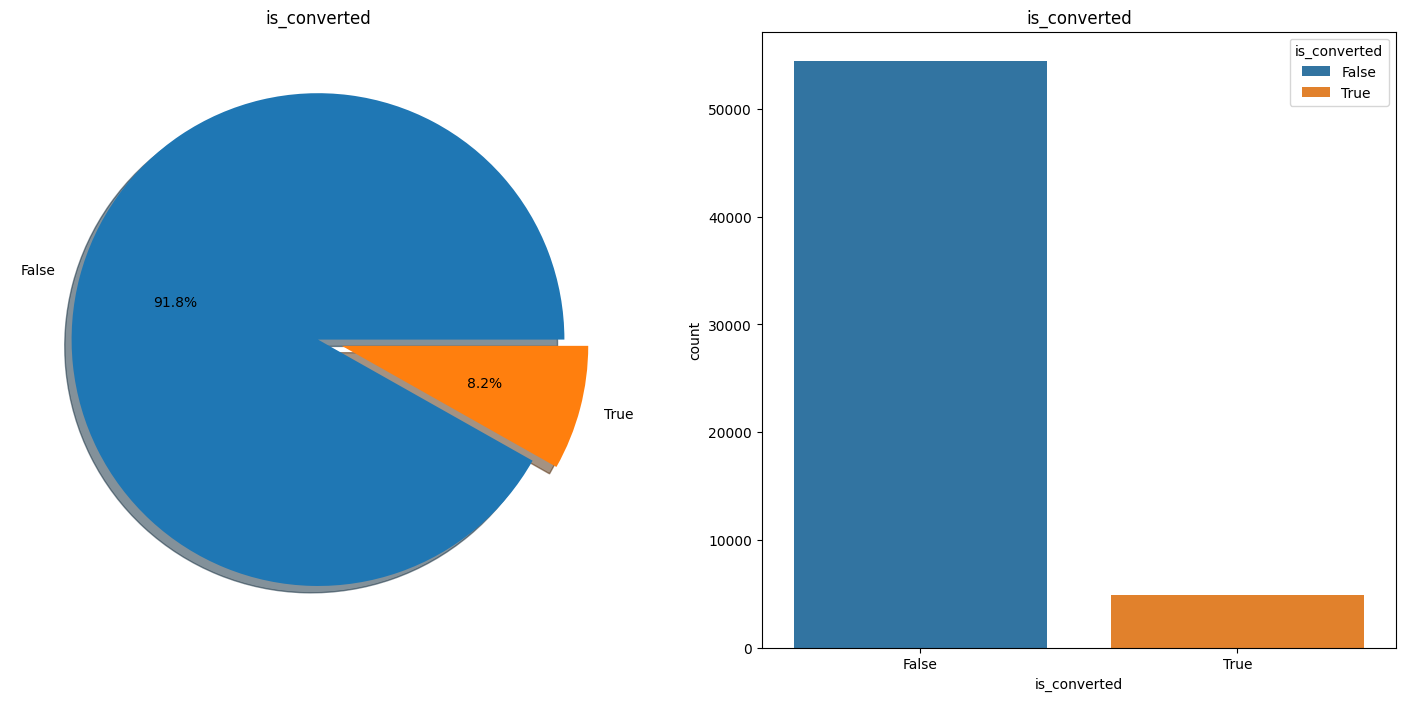

In [11]:
f,ax = plt.subplots(1,2,figsize=(18,8))
df_train['is_converted'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('is_converted')
ax[0].set_ylabel('')
sns.countplot(x = 'is_converted', hue='is_converted', data = df_train, ax=ax[1])
ax[1].set_title('is_converted')
plt.show()

#### business_unit vs is_converted

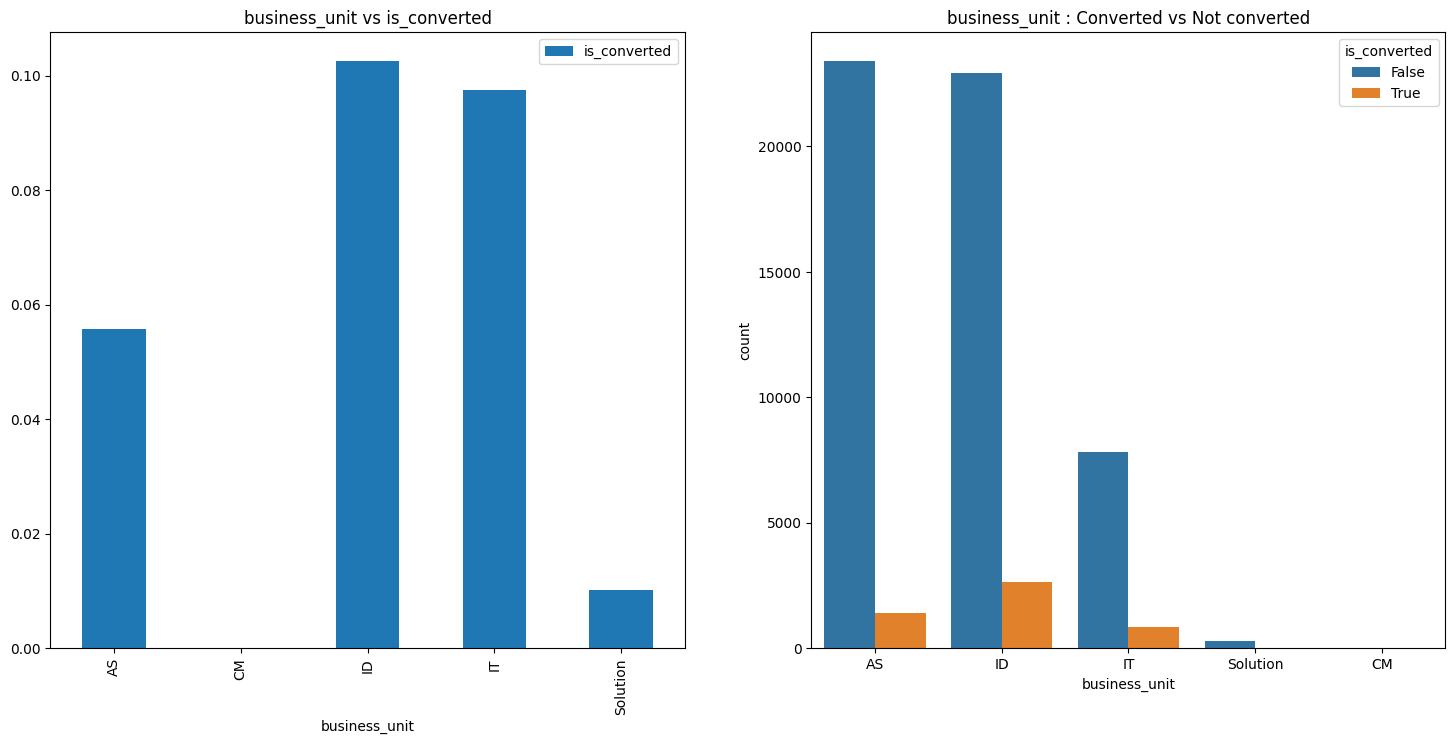

In [62]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df_train[['business_unit','is_converted']].groupby(['business_unit']).mean().plot.bar(ax=ax[0])
ax[0].set_title('business_unit vs is_converted')
sns.countplot(x = 'business_unit',hue='is_converted',data = df_train,ax=ax[1])
ax[1].set_title('business_unit : Converted vs Not converted')
plt.show()

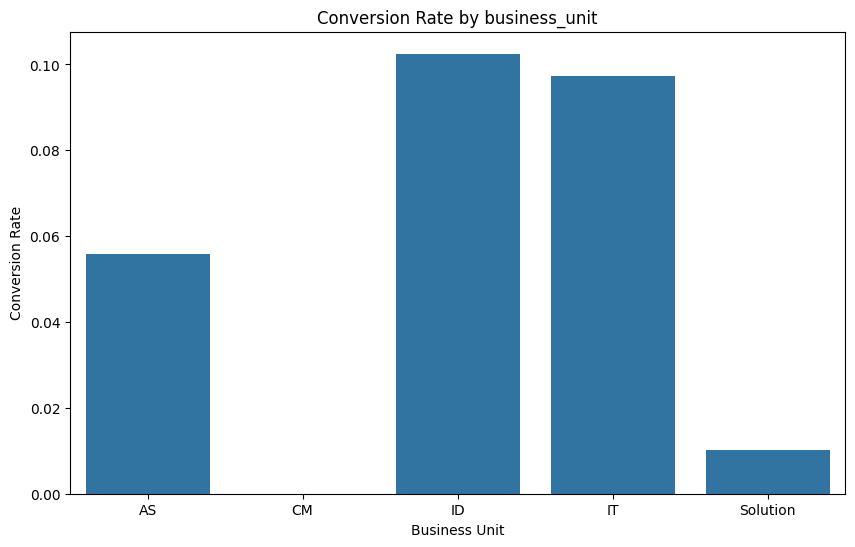

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그림 생성
plt.figure(figsize=(10, 6))

# business_unit 별 is_converted 비율 계산
conversion_rate = df_train.groupby('business_unit')['is_converted'].mean().reset_index()

# 그래프 그리기
sns.barplot(x='business_unit', y='is_converted', data=conversion_rate)
plt.title('Conversion Rate by business_unit')
plt.xlabel('Business Unit')
plt.ylabel('Conversion Rate')
plt.show()


In [ ]:
# business_unit이 ID일 때, 전환 고객 수가 가장 많음. 따라서, ID 그룹에 속하면 고객으로 전환될 가능성이 높다고 결론 내릴 수 있음. 

## 2. 데이터 전처리

### 레이블 인코딩

In [9]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [10]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

다시 학습 데이터와 제출 데이터를 분리합니다.

In [11]:
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2-2. 학습, 검증 데이터 분리

In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
)

## 3. 모델 학습

### 모델 정의 

In [1]:
# pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.3 MB 5.3 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.3 MB 7.5 MB/s eta 0:00:01
   --------------------------- ------------ 0.9/1.3 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 7.7 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 7.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
from lightgbm import LGBMClassifier

# LightGBM 
model = LGBMClassifier()

### 모델 학습

In [14]:
model.fit(x_train.fillna(0), y_train)

[LightGBM] [Info] Number of positive: 3903, number of negative: 43536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2702
[LightGBM] [Info] Number of data points in the train set: 47439, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082274 -> initscore=-2.411843
[LightGBM] [Info] Start training from score -2.411843


LGBMClassifier()

### 모델 성능 보기

In [15]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [16]:
pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)

오차행렬:
 [[  659   288]
 [   65 10848]]

정확도: 0.9702
정밀도: 0.9102
재현율: 0.6959
F1: 0.7887


## 4. 제출하기

### 테스트 데이터 예측

In [12]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [13]:
test_pred = model.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

1157

### 제출 파일 작성

In [14]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**